# Investigating False Positives of the Topology (Persistent Homology) Detector

This notebook stress-tests **false positives** for the topology-based detector (`detector_type='topology_score'`).

We measure how often **benign** new samples are flagged as adversarial when we inject new samples.

## What we test

- **IID new samples**: fresh two-moons samples from the same generator/noise.
- **Local jitter**: small Gaussian perturbations around clean test points.
- **Noise shift**: new two-moons samples with a different noise level.
- (Optional sanity) **Uniform OOD background**: random points in a bounding box.

## Outputs

- Flag rate per scenario ("false positive" rate for benign scenarios)
- Sensitivity to threshold percentile (90/95/97.5/99)
- Plots showing score distributions + which new points get flagged

## Note on compute

Persistent homology is more expensive than simple graph scores. If this notebook feels slow, reduce `N_NEW` and/or `BASE_CONFIG.graph.topo_k`.



In [1]:
# Imports + path setup
import os
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt

# Ensure project root is on path
CWD = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CWD, "..")) if os.path.basename(CWD) == "notebooks" else os.path.abspath(CWD)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Topology detector dependency check
try:
    importlib.import_module("ripser")
    print("ripser is available")
except Exception as e:
    raise ImportError(
        "ripser is required for the topology detector in this notebook.\n"
        "Install into this Jupyter kernel env:\n"
        "  python -m pip install ripser\n"
        "Then restart the kernel and rerun."
    ) from e

from src.data import generate_two_moons, create_data_loaders
from src.models import TwoMoonsMLP, train_model, extract_features_batch, get_model_logits
from src.adv_attacks import generate_adversarial_examples
from src.graph_scoring import compute_graph_scores
from src.detectors import train_graph_detector
from src.utils import ExperimentConfig, set_seed

# Optional convenience
try:
    pd = importlib.import_module("pandas")
except Exception:
    pd = None

print(f"CWD: {CWD}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"src exists: {os.path.exists(os.path.join(PROJECT_ROOT, 'src'))}")



ripser is available
CWD: /Users/svenhockers/Documents/code_files/topology-and-robustness-in-DNNs/notebooks
PROJECT_ROOT: /Users/svenhockers/Documents/code_files/topology-and-robustness-in-DNNs
src exists: True


In [2]:
# Experiment configuration
BASE_SEEDS = [1, 2, 3, 4, 5]
THRESHOLD_PERCENTILES = [90, 95, 97.5, 99]

# Keep training fairly light (adjust if you want maximum accuracy)
BASE_CONFIG = ExperimentConfig(seed=42, device='cpu')
BASE_CONFIG.data.n_samples = 1000
BASE_CONFIG.data.noise = 0.1
BASE_CONFIG.model.epochs = 50
BASE_CONFIG.model.learning_rate = 1e-3

# Neighborhoods computed in feature space (recommended)
BASE_CONFIG.graph.space = 'feature'
BASE_CONFIG.graph.k = 10

# Enable topology features (persistent homology)
BASE_CONFIG.graph.use_topology = True
BASE_CONFIG.graph.topo_k = 50
BASE_CONFIG.graph.topo_maxdim = 1
BASE_CONFIG.graph.topo_min_persistence = 1e-6

# Detector: topology score (PH features -> Mahalanobis -> percentile threshold)
BASE_CONFIG.detector.detector_type = 'topology_score'
BASE_CONFIG.detector.topo_cov_shrinkage = 1e-3

BASE_CONFIG.attack.attack_type = 'fgsm'
BASE_CONFIG.attack.epsilon = 0.1

# How many new points to inject per scenario (per seed)
# PH is expensive; reduce this if runtime is high.
N_NEW = 300

# Jitter strengths for benign local perturbations
JITTER_SIGMAS = [0.01, 0.03, 0.05]

# Noise shifts for generator
NOISE_SHIFTS = [0.05, 0.15, 0.25]



In [3]:
# Fast batched score computation (matches src.graph_scoring logic, but avoids per-point kNN refits)
import torch
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from typing import Optional, Dict


def _sigma_from_training(Z_train: np.ndarray) -> float:
    # Matches src.graph_scoring.compute_*_score when sigma=None
    # (it uses median of pairwise distances over the entire training set)
    return float(np.median(pdist(Z_train)))


def compute_graph_scores_fast(
    X_points: np.ndarray,
    model,
    Z_train: np.ndarray,
    f_train: np.ndarray,
    *,
    k: int,
    sigma: Optional[float],
    space: str,
    device: str = 'cpu',
) -> Dict[str, np.ndarray]:
    """Return {'degree': ..., 'laplacian': ...} for X_points."""
    if space == 'feature':
        Z_points = extract_features_batch(model, X_points, layer='penultimate', device=device)
    else:
        Z_points = X_points

    logits = get_model_logits(model, X_points, device=device)
    probs = torch.softmax(torch.as_tensor(logits, dtype=torch.float32), dim=1).cpu().numpy()
    f_points = probs[:, 1]

    if sigma is None:
        sigma = _sigma_from_training(Z_train)

    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(Z_train)
    distances, indices = nbrs.kneighbors(Z_points)

    weights = np.exp(-(distances ** 2) / (2 * (sigma ** 2)))

    degree_scores = -weights.sum(axis=1)
    laplacian_scores = np.sum(weights * (f_points[:, None] - f_train[indices]) ** 2, axis=1)

    return {'degree': degree_scores, 'laplacian': laplacian_scores}


# Quick correctness check vs the reference implementation on a tiny batch (optional)
from src.graph_scoring import compute_graph_scores as compute_graph_scores_ref

def sanity_check_scores(model, X_points, Z_train, f_train, config):
    X_small = X_points[:10]
    ref = compute_graph_scores_ref(X_small, model, Z_train, f_train, config.graph, device=config.device)
    fast = compute_graph_scores_fast(
        X_small, model, Z_train, f_train,
        k=config.graph.k, sigma=config.graph.sigma, space=config.graph.space, device=config.device
    )
    for key in ['degree', 'laplacian']:
        max_abs = float(np.max(np.abs(ref[key] - fast[key])))
        print(f"{key}: max |ref-fast| = {max_abs:.6e}")



In [4]:
# Train model + build graph reference set + train detector threshold
from copy import deepcopy


from typing import Optional

def make_config(seed: int, *, noise: Optional[float] = None) -> ExperimentConfig:
    cfg = ExperimentConfig(seed=seed, device=BASE_CONFIG.device)
    # data
    cfg.data.n_samples = BASE_CONFIG.data.n_samples
    cfg.data.noise = BASE_CONFIG.data.noise if noise is None else float(noise)
    cfg.data.random_state = seed
    # model
    cfg.model.epochs = BASE_CONFIG.model.epochs
    cfg.model.learning_rate = BASE_CONFIG.model.learning_rate
    cfg.model.batch_size = BASE_CONFIG.model.batch_size
    # attack
    cfg.attack.attack_type = BASE_CONFIG.attack.attack_type
    cfg.attack.epsilon = BASE_CONFIG.attack.epsilon
    # graph / topology
    cfg.graph.k = BASE_CONFIG.graph.k
    cfg.graph.sigma = BASE_CONFIG.graph.sigma
    cfg.graph.space = BASE_CONFIG.graph.space
    cfg.graph.use_topology = BASE_CONFIG.graph.use_topology
    cfg.graph.topo_k = BASE_CONFIG.graph.topo_k
    cfg.graph.topo_maxdim = BASE_CONFIG.graph.topo_maxdim
    cfg.graph.topo_thresh = BASE_CONFIG.graph.topo_thresh
    cfg.graph.topo_min_persistence = BASE_CONFIG.graph.topo_min_persistence
    # detector
    cfg.detector.detector_type = BASE_CONFIG.detector.detector_type
    cfg.detector.topo_cov_shrinkage = BASE_CONFIG.detector.topo_cov_shrinkage
    return cfg


def train_pipeline(seed: int, *, include_adv_test: bool = False):
    """Train classifier; compute Z_train, f_train; generate adv-val for detector training."""
    set_seed(seed)
    config = make_config(seed)

    X_train, y_train, X_val, y_val, X_test, y_test = generate_two_moons(
        n_samples=config.data.n_samples,
        noise=config.data.noise,
        random_state=config.data.random_state,
        train_ratio=config.data.train_ratio,
        val_ratio=config.data.val_ratio,
        test_ratio=config.data.test_ratio,
    )

    train_loader, val_loader, test_loader = create_data_loaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch_size=config.model.batch_size
    )

    model = TwoMoonsMLP(
        input_dim=config.model.input_dim,
        hidden_dims=config.model.hidden_dims,
        output_dim=config.model.output_dim,
        activation=config.model.activation,
    )

    history = train_model(model, train_loader, val_loader, config.model, device=config.device, verbose=False)

    # Reference representations for local neighborhoods
    if config.graph.space == 'feature':
        Z_train = extract_features_batch(model, X_train, layer='penultimate', device=config.device)
    else:
        Z_train = X_train

    logits_train = get_model_logits(model, X_train, device=config.device)
    probs_train = torch.softmax(torch.as_tensor(logits_train, dtype=torch.float32), dim=1).cpu().numpy()
    f_train = probs_train[:, 1]

    # Adversarial examples used only for detector thresholding (positives)
    X_adv_val = generate_adversarial_examples(model, X_val, y_val, config.attack, device=config.device)

    X_adv_test = None
    scores_test_adv = None
    if include_adv_test:
        X_adv_test = generate_adversarial_examples(model, X_test, y_test, config.attack, device=config.device)
        scores_test_adv = compute_graph_scores(
            X_adv_test, model, Z_train, f_train, config.graph, device=config.device
        )

    # Scores (including topo_* keys) on validation and clean test sets
    scores_val_clean = compute_graph_scores(
        X_val, model, Z_train, f_train, config.graph, device=config.device
    )
    scores_val_adv = compute_graph_scores(
        X_adv_val, model, Z_train, f_train, config.graph, device=config.device
    )
    scores_test_clean = compute_graph_scores(
        X_test, model, Z_train, f_train, config.graph, device=config.device
    )

    bundle = {
        'seed': seed,
        'config': config,
        'model': model,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'Z_train': Z_train,
        'f_train': f_train,
        'scores_val_clean': scores_val_clean,
        'scores_val_adv': scores_val_adv,
        'scores_test_clean': scores_test_clean,
        'X_adv_test': X_adv_test,
        'scores_test_adv': scores_test_adv,
        'history': history,
    }
    return bundle


def fit_topology_percentile_detector(bundle, *, percentile: float):
    """Fit the topology detector; threshold uses ONLY clean validation scores."""
    scores_val_clean = bundle['scores_val_clean']
    scores_val_adv = bundle['scores_val_adv']

    # Combine scores; train_graph_detector expects clean+adv in one dict + labels.
    scores_val_all = {k: np.concatenate([scores_val_clean[k], scores_val_adv[k]]) for k in scores_val_clean.keys()}
    any_key = next(iter(scores_val_clean.keys()))
    labels_val = np.concatenate([
        np.zeros(len(scores_val_clean[any_key]), dtype=int),
        np.ones(len(scores_val_adv[any_key]), dtype=int),
    ])

    det_cfg = deepcopy(bundle['config'].detector)
    det_cfg.detector_type = 'topology_score'
    det_cfg.topo_percentile = float(percentile)

    det = train_graph_detector(scores_val_all, labels_val, det_cfg)
    return det



In [5]:
# Benign injection scenarios
from sklearn.datasets import make_moons


def generate_iid_new(n: int, *, noise: float, seed: int):
    X, y = make_moons(n_samples=n, noise=noise, random_state=seed)
    return X, y


def generate_local_jitter(X_base: np.ndarray, n: int, *, sigma: float, seed: int):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X_base), size=n, replace=True)
    X = X_base[idx] + rng.normal(loc=0.0, scale=sigma, size=(n, X_base.shape[1]))
    return X


def generate_uniform_ood(n: int, *, X_ref: np.ndarray, seed: int, margin: float = 0.5):
    rng = np.random.default_rng(seed)
    lo = X_ref.min(axis=0) - margin
    hi = X_ref.max(axis=0) + margin
    X = rng.uniform(low=lo, high=hi, size=(n, X_ref.shape[1]))
    return X


def score_and_flag(bundle, det, X_points):
    config = bundle['config']
    X_points = np.asarray(X_points, dtype=float)
    scores = compute_graph_scores(
        X_points,
        bundle['model'],
        bundle['Z_train'],
        bundle['f_train'],
        config.graph,
        device=config.device,
    )
    preds = det.predict(scores)
    return scores, preds



In [6]:
# Run FP experiments (topology detector)
results = []

for seed in BASE_SEEDS:
    bundle = train_pipeline(seed)

    for percentile in THRESHOLD_PERCENTILES:
        det = fit_topology_percentile_detector(bundle, percentile=float(percentile))
        thr = getattr(det, 'threshold', None)
        assert thr is not None
        thr_f = float(thr)

        # Baseline: held-out clean test set
        preds_test = det.predict(bundle['scores_test_clean'])
        results.append({
            'seed': seed,
            'percentile': float(percentile),
            'scenario': 'clean_test',
            'n': int(len(preds_test)),
            'fp_rate': float(preds_test.mean()),
            'threshold': thr_f,
        })

        # IID new samples
        X_iid, _ = generate_iid_new(N_NEW, noise=bundle['config'].data.noise, seed=seed + 1000)
        _, preds = score_and_flag(bundle, det, X_iid)
        results.append({
            'seed': seed,
            'percentile': float(percentile),
            'scenario': f'iid_new_noise={bundle["config"].data.noise}',
            'n': int(len(preds)),
            'fp_rate': float(preds.mean()),
            'threshold': thr_f,
        })

        # Local jitter around clean test points
        for sigma in JITTER_SIGMAS:
            X_jit = generate_local_jitter(bundle['X_test'], N_NEW, sigma=float(sigma), seed=seed + 2000 + int(1000 * sigma))
            _, preds = score_and_flag(bundle, det, X_jit)
            results.append({
                'seed': seed,
                'percentile': float(percentile),
                'scenario': f'local_jitter_sigma={sigma}',
                'n': int(len(preds)),
                'fp_rate': float(preds.mean()),
                'threshold': thr_f,
            })

        # Noise shift: still two-moons, but different noise levels
        for noise in NOISE_SHIFTS:
            X_shift, _ = generate_iid_new(N_NEW, noise=float(noise), seed=seed + 3000 + int(1000 * noise))
            _, preds = score_and_flag(bundle, det, X_shift)
            results.append({
                'seed': seed,
                'percentile': float(percentile),
                'scenario': f'noise_shift_noise={noise}',
                'n': int(len(preds)),
                'fp_rate': float(preds.mean()),
                'threshold': thr_f,
            })

        # (Sanity) Uniform background points in a box around training data
        X_ood = generate_uniform_ood(N_NEW, X_ref=bundle['X_train'], seed=seed + 4000)
        _, preds = score_and_flag(bundle, det, X_ood)
        results.append({
            'seed': seed,
            'percentile': float(percentile),
            'scenario': 'uniform_ood_box',
            'n': int(len(preds)),
            'fp_rate': float(preds.mean()),
            'threshold': thr_f,
        })

# Summarize
if pd is not None:
    df = pd.DataFrame(results)
    display(df.head())

    summary = (
        df.groupby(['scenario', 'percentile'])['fp_rate']
          .agg(['mean', 'std', 'count'])
          .reset_index()
          .sort_values(['scenario', 'percentile'])
    )
    display(summary)
else:
    # Minimal fallback summary
    from collections import defaultdict
    agg = defaultdict(list)
    for r in results:
        agg[(r['scenario'], r['percentile'])].append(r['fp_rate'])
    for (scenario, percentile), vals in sorted(agg.items()):
        vals = np.asarray(vals)
        print(f"{scenario:25s} p={percentile:5.1f}  mean={vals.mean():.4f}  std={vals.std():.4f}  n_seeds={len(vals)}")



clean_test                p= 90.0  mean=0.1160  std=0.0302  n_seeds=5
clean_test                p= 95.0  mean=0.0620  std=0.0286  n_seeds=5
clean_test                p= 97.5  mean=0.0370  std=0.0186  n_seeds=5
clean_test                p= 99.0  mean=0.0110  std=0.0037  n_seeds=5
iid_new_noise=0.1         p= 90.0  mean=0.1093  std=0.0404  n_seeds=5
iid_new_noise=0.1         p= 95.0  mean=0.0580  std=0.0265  n_seeds=5
iid_new_noise=0.1         p= 97.5  mean=0.0327  std=0.0170  n_seeds=5
iid_new_noise=0.1         p= 99.0  mean=0.0133  std=0.0030  n_seeds=5
local_jitter_sigma=0.01   p= 90.0  mean=0.1033  std=0.0209  n_seeds=5
local_jitter_sigma=0.01   p= 95.0  mean=0.0567  std=0.0216  n_seeds=5
local_jitter_sigma=0.01   p= 97.5  mean=0.0347  std=0.0169  n_seeds=5
local_jitter_sigma=0.01   p= 99.0  mean=0.0127  std=0.0068  n_seeds=5
local_jitter_sigma=0.03   p= 90.0  mean=0.1287  std=0.0258  n_seeds=5
local_jitter_sigma=0.03   p= 95.0  mean=0.0740  std=0.0193  n_seeds=5
local_jitter_sigma=0

In [7]:
# Plot FP rate vs threshold percentile (requires pandas)
if pd is not None:
    # Focus plots on benign-ish scenarios
    scenarios_to_plot = [
        'clean_test',
        f'iid_new_noise={BASE_CONFIG.data.noise}',
        *[f'local_jitter_sigma={s}' for s in JITTER_SIGMAS],
        *[f'noise_shift_noise={n}' for n in NOISE_SHIFTS],
        'uniform_ood_box',
    ]

    df_plot = df[df['scenario'].isin(scenarios_to_plot)].copy()

    fig, ax = plt.subplots(figsize=(12, 5))
    for scenario in scenarios_to_plot:
        sub = df_plot[df_plot['scenario'] == scenario]
        g = sub.groupby('percentile')['fp_rate'].mean().reset_index()
        ax.plot(g['percentile'], g['fp_rate'], marker='o', label=scenario)

    ax.set_xlabel('Threshold percentile (of clean validation scores)')
    ax.set_ylabel('Flag rate on injected points ("FP rate" for benign scenarios)')
    ax.set_title('False positive / flag rates vs threshold percentile (topology_score)')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()



Example seed=1, percentile=95, scenario=IID new: flag-rate=0.1100
Threshold (topology_mahalanobis) = 3.365263


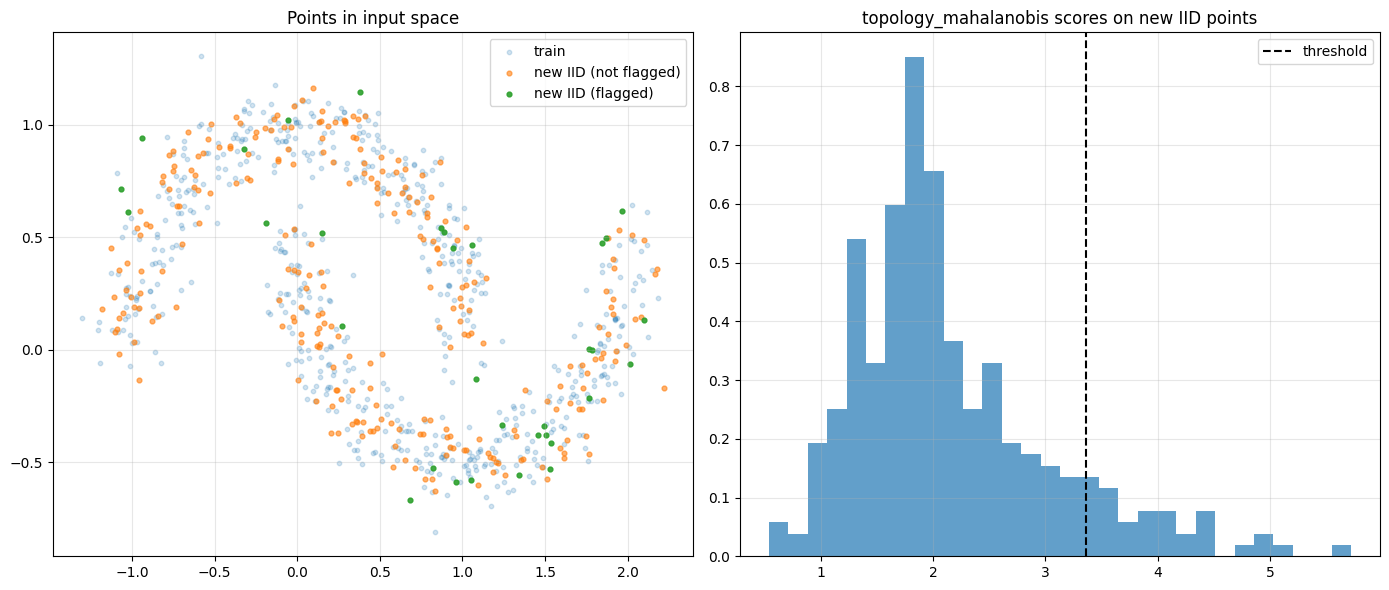

In [8]:
# Visualize which *new* points get flagged (single example run)
EXAMPLE_SEED = BASE_SEEDS[0]
EXAMPLE_PERCENTILE = 95

bundle = train_pipeline(EXAMPLE_SEED)
det = fit_topology_percentile_detector(bundle, percentile=float(EXAMPLE_PERCENTILE))
thr = getattr(det, 'threshold', None)
assert thr is not None
thr_f = float(thr)

X_iid, y_iid = generate_iid_new(N_NEW, noise=bundle['config'].data.noise, seed=EXAMPLE_SEED + 1000)
X_iid = np.asarray(X_iid, dtype=float)
scores_iid, preds_iid = score_and_flag(bundle, det, X_iid)

fp_rate = float(preds_iid.mean())
print(f"Example seed={EXAMPLE_SEED}, percentile={EXAMPLE_PERCENTILE}, scenario=IID new: flag-rate={fp_rate:.4f}")
print(f"Threshold (topology_mahalanobis) = {thr_f:.6f}")

# Scatter: train set + new IID points, highlighting flagged
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

mask = preds_iid.astype(bool)
X_nf = X_iid[~mask]
X_f = X_iid[mask]

axes[0].scatter(bundle['X_train'][:, 0], bundle['X_train'][:, 1], s=10, alpha=0.2, label='train')
axes[0].scatter(X_nf[:, 0], X_nf[:, 1], s=12, alpha=0.6, label='new IID (not flagged)')
axes[0].scatter(X_f[:, 0], X_f[:, 1], s=12, alpha=0.9, label='new IID (flagged)')
axes[0].set_title('Points in input space')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Score distribution + threshold
score_fn = getattr(det, 'score', None)
assert callable(score_fn)
raw_scores_iid = np.asarray(score_fn(scores_iid), dtype=float)
axes[1].hist(raw_scores_iid, bins=30, alpha=0.7, density=True)
axes[1].axvline(thr_f, color='k', linestyle='--', label='threshold')
axes[1].set_title("topology_mahalanobis scores on new IID points")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



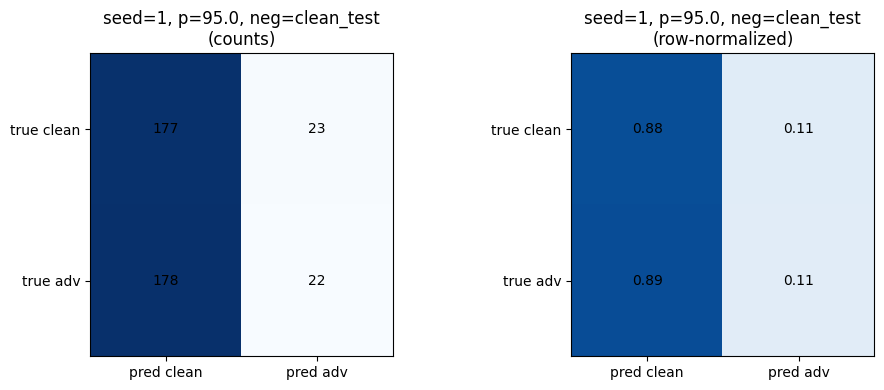

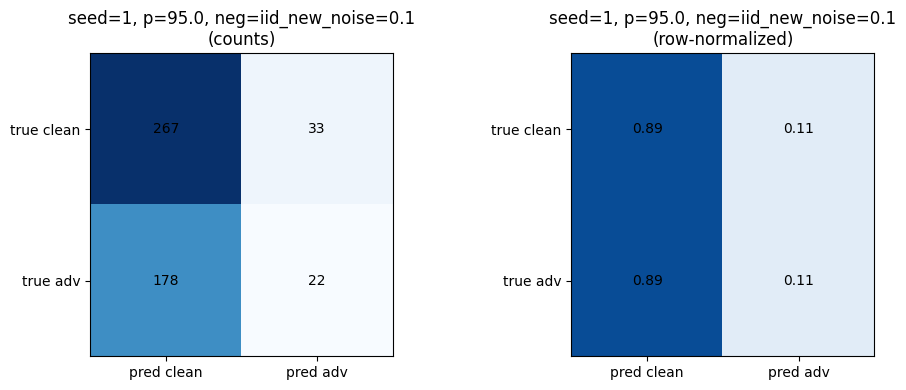

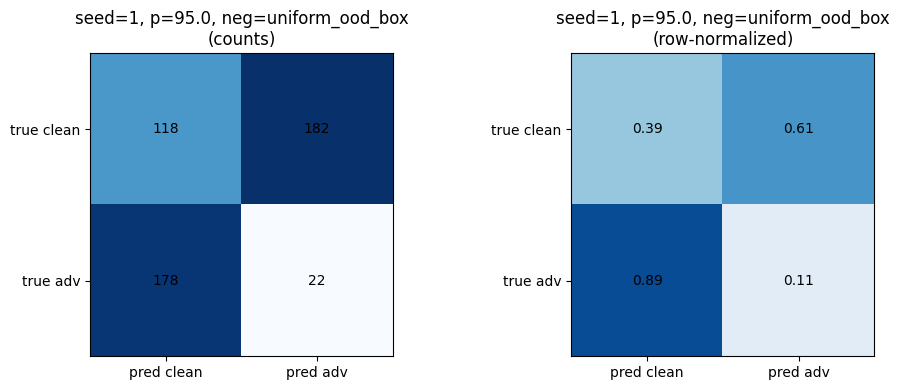

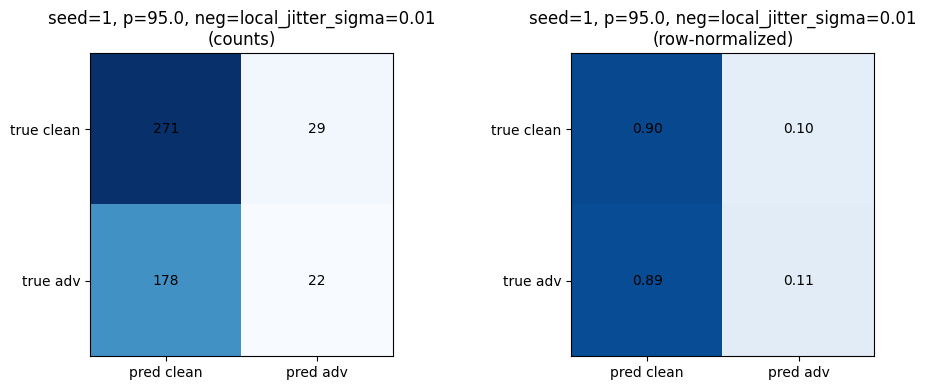

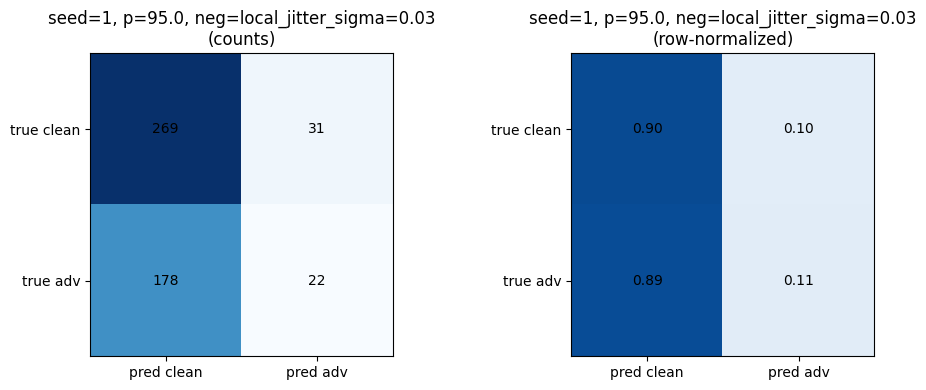

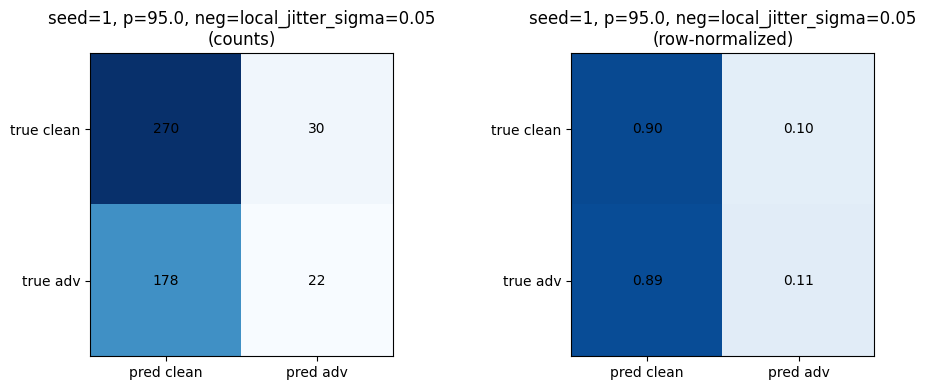

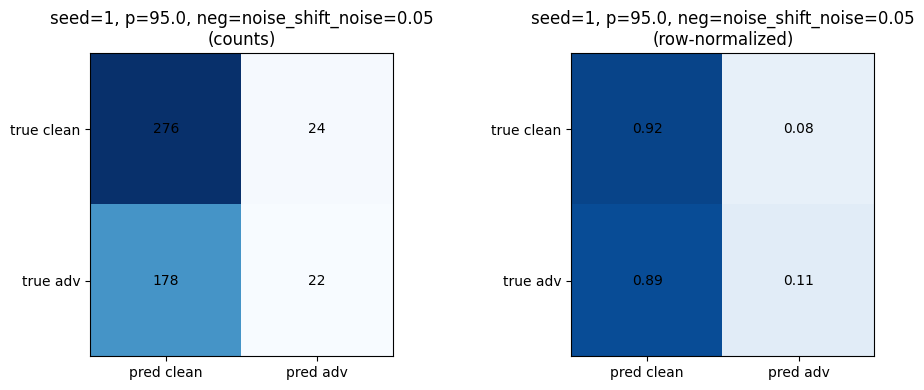

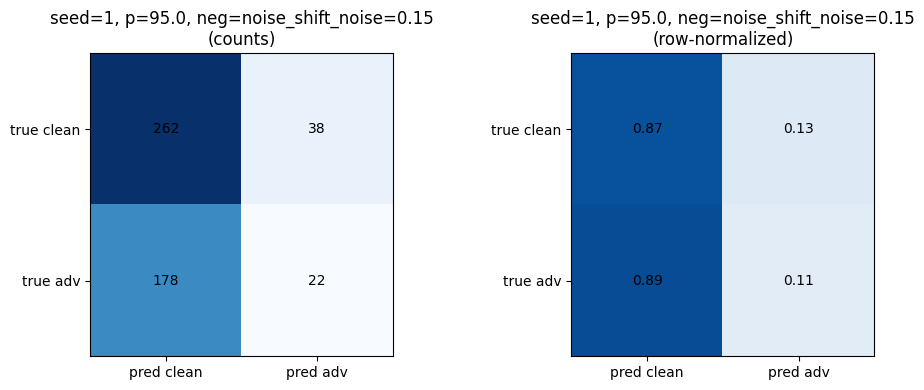

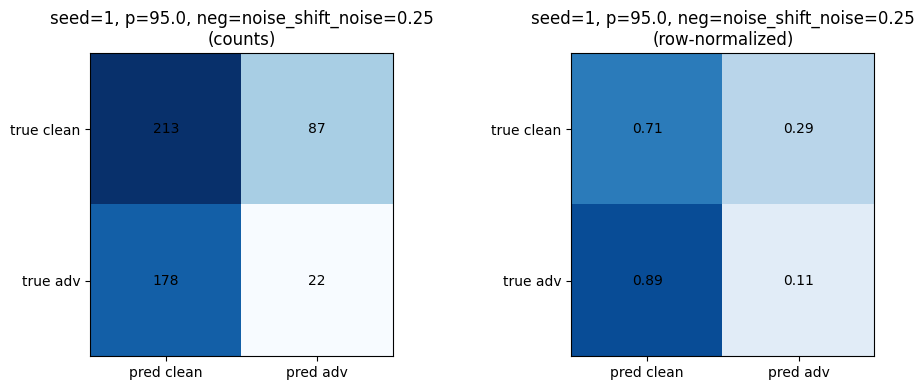

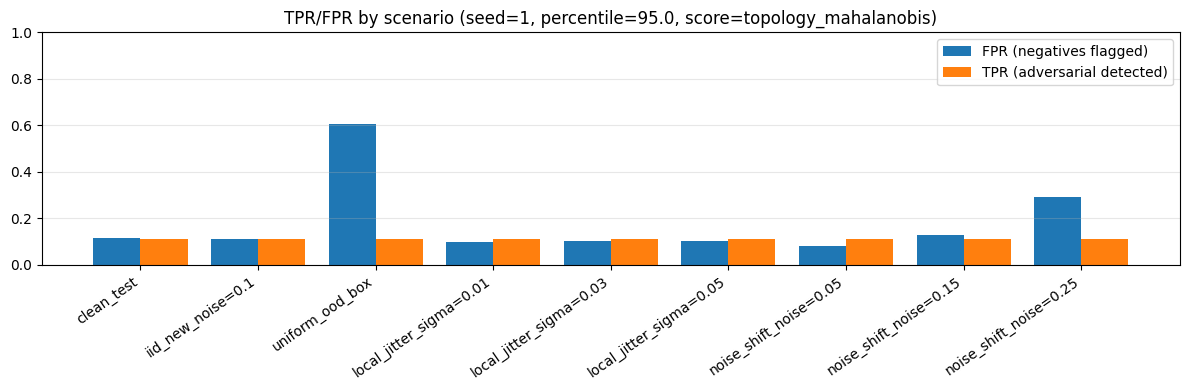

clean_test                 TPR=0.110  FPR=0.115  (TP=22 FP=23 TN=177 FN=178)
iid_new_noise=0.1          TPR=0.110  FPR=0.110  (TP=22 FP=33 TN=267 FN=178)
local_jitter_sigma=0.01    TPR=0.110  FPR=0.097  (TP=22 FP=29 TN=271 FN=178)
local_jitter_sigma=0.03    TPR=0.110  FPR=0.103  (TP=22 FP=31 TN=269 FN=178)
local_jitter_sigma=0.05    TPR=0.110  FPR=0.100  (TP=22 FP=30 TN=270 FN=178)
noise_shift_noise=0.05     TPR=0.110  FPR=0.080  (TP=22 FP=24 TN=276 FN=178)
noise_shift_noise=0.15     TPR=0.110  FPR=0.127  (TP=22 FP=38 TN=262 FN=178)
noise_shift_noise=0.25     TPR=0.110  FPR=0.290  (TP=22 FP=87 TN=213 FN=178)
uniform_ood_box            TPR=0.110  FPR=0.607  (TP=22 FP=182 TN=118 FN=178)


In [9]:
# Confusion matrices (TP / FP / TN / FN) for benign injections vs adversarial test positives

def confusion_counts(y_true: np.ndarray, y_pred: np.ndarray):
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))
    return tp, fp, tn, fn


def rates_from_counts(tp: int, fp: int, tn: int, fn: int):
    tpr = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    fpr = fp / (fp + tn) if (fp + tn) > 0 else float('nan')
    return tpr, fpr


def plot_confusion(tp: int, fp: int, tn: int, fn: int, *, title: str):
    cm = np.array([[tn, fp], [fn, tp]], dtype=float)
    cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].imshow(cm, cmap='Blues')
    axes[0].set_title(title + "\n(counts)")
    axes[0].set_xticks([0, 1]); axes[0].set_yticks([0, 1])
    axes[0].set_xticklabels(['pred clean', 'pred adv'])
    axes[0].set_yticklabels(['true clean', 'true adv'])
    for (i, j), val in np.ndenumerate(cm):
        axes[0].text(j, i, f"{int(val)}", ha='center', va='center')

    axes[1].imshow(cm_norm, vmin=0, vmax=1, cmap='Blues')
    axes[1].set_title(title + "\n(row-normalized)")
    axes[1].set_xticks([0, 1]); axes[1].set_yticks([0, 1])
    axes[1].set_xticklabels(['pred clean', 'pred adv'])
    axes[1].set_yticklabels(['true clean', 'true adv'])
    for (i, j), val in np.ndenumerate(cm_norm):
        axes[1].text(j, i, f"{val:.2f}", ha='center', va='center')

    plt.tight_layout()
    plt.show()


CM_SEED = BASE_SEEDS[0]
CM_PERCENTILE = 95.0

bundle_cm = train_pipeline(CM_SEED, include_adv_test=True)

# Detector threshold from val clean
cm_det = fit_topology_percentile_detector(bundle_cm, percentile=float(CM_PERCENTILE))
thr = getattr(cm_det, 'threshold', None)
assert thr is not None
thr_f = float(thr)

# Positives: adversarial test
assert bundle_cm.get('scores_test_adv') is not None, "Expected adversarial test scores"
y_pos = np.ones(len(bundle_cm['scores_test_adv'][next(iter(bundle_cm['scores_test_adv'].keys()))]), dtype=int)
pred_fn = getattr(cm_det, 'predict', None)
assert callable(pred_fn)
p_pos = pred_fn(bundle_cm['scores_test_adv'])
p_pos = np.asarray(p_pos, dtype=int)

# Define benign-negative scenarios
neg_scenarios = {
    'clean_test': bundle_cm['X_test'],
    f'iid_new_noise={bundle_cm["config"].data.noise}': generate_iid_new(N_NEW, noise=bundle_cm['config'].data.noise, seed=CM_SEED + 1000)[0],
    'uniform_ood_box': generate_uniform_ood(N_NEW, X_ref=bundle_cm['X_train'], seed=CM_SEED + 4000),
}
for s in JITTER_SIGMAS:
    neg_scenarios[f'local_jitter_sigma={s}'] = generate_local_jitter(bundle_cm['X_test'], N_NEW, sigma=float(s), seed=CM_SEED + 2000 + int(1000 * s))
for n in NOISE_SHIFTS:
    neg_scenarios[f'noise_shift_noise={n}'] = generate_iid_new(N_NEW, noise=float(n), seed=CM_SEED + 3000 + int(1000 * n))[0]

# Build and plot confusion matrices per negative scenario
rows = []
for scenario, X_neg in neg_scenarios.items():
    if scenario == 'clean_test':
        scores_neg = bundle_cm['scores_test_clean']
    else:
        scores_neg = compute_graph_scores(
            np.asarray(X_neg, dtype=float),
            bundle_cm['model'],
            bundle_cm['Z_train'],
            bundle_cm['f_train'],
            bundle_cm['config'].graph,
            device=bundle_cm['config'].device,
        )

    y_neg = np.zeros(len(X_neg), dtype=int)
    p_neg = pred_fn(scores_neg)
    p_neg = np.asarray(p_neg, dtype=int)

    y_all = np.concatenate([y_neg, y_pos])
    p_all = np.concatenate([p_neg, p_pos])

    tp, fp, tn, fn = confusion_counts(y_all, p_all)
    tpr, fpr = rates_from_counts(tp, fp, tn, fn)

    rows.append({
        'scenario': scenario,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'TPR': tpr,
        'FPR': fpr,
        'threshold': thr_f,
        'percentile': float(CM_PERCENTILE),
        'seed': int(CM_SEED),
    })

    plot_confusion(tp, fp, tn, fn, title=f"seed={CM_SEED}, p={CM_PERCENTILE}, neg={scenario}")

# Summarize rates in a bar chart
labels = [r['scenario'] for r in rows]
fprs = [r['FPR'] for r in rows]
tprs = [r['TPR'] for r in rows]

fig, ax = plt.subplots(figsize=(12, 4))
x = np.arange(len(labels))
ax.bar(x - 0.2, fprs, width=0.4, label='FPR (negatives flagged)')
ax.bar(x + 0.2, tprs, width=0.4, label='TPR (adversarial detected)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=35, ha='right')
ax.set_ylim(0, 1)
ax.set_title(f"TPR/FPR by scenario (seed={CM_SEED}, percentile={CM_PERCENTILE}, score=topology_mahalanobis)")
ax.grid(True, axis='y', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

if pd is not None:
    display(pd.DataFrame(rows).sort_values('scenario'))
else:
    for r in sorted(rows, key=lambda d: d['scenario']):
        print(f"{r['scenario']:25s}  TPR={r['TPR']:.3f}  FPR={r['FPR']:.3f}  (TP={r['TP']} FP={r['FP']} TN={r['TN']} FN={r['FN']})")



In [10]:
# Visualize the local kNN graph neighborhood used to score/flag a point
from sklearn.neighbors import NearestNeighbors

try:
    from sklearn.decomposition import PCA
except Exception:
    PCA = None


def _get_Z_points(bundle, X_points: np.ndarray):
    cfg = bundle['config']
    if cfg.graph.space == 'feature':
        return extract_features_batch(bundle['model'], X_points, layer='penultimate', device=cfg.device)
    return X_points


def _get_f_points(bundle, X_points: np.ndarray) -> np.ndarray:
    logits = get_model_logits(bundle['model'], X_points, device=bundle['config'].device)
    probs = torch.softmax(torch.as_tensor(logits, dtype=torch.float32), dim=1).cpu().numpy()
    return probs[:, 1]


from typing import Optional, Any

def visualize_point_graph_neighborhood(
    bundle,
    det: Any,
    x: np.ndarray,
    *,
    score_type: str = 'laplacian',
    k: Optional[int] = None,
    title: str = "",
    plot_space: str = 'input',  # 'input' or 'feature_pca'
    zoom: bool = True,
    zoom_margin: float = 0.35,
):
    """Visualize the kNN edges used to compute the score for one point x.

    Even if the scoring space is 'feature', we can still draw the neighborhood in input space for intuition.
    """
    cfg = bundle['config']
    if k is None:
        k = cfg.graph.k

    x = np.asarray(x).reshape(1, -1)

    Z_train = bundle['Z_train']
    f_train = bundle['f_train']

    z = _get_Z_points(bundle, x)
    f_z = float(_get_f_points(bundle, x)[0])

    if cfg.graph.sigma is None:
        sigma = _sigma_from_training(Z_train)
    else:
        sigma = float(cfg.graph.sigma)

    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(Z_train)
    distances, indices = nbrs.kneighbors(z)
    distances = distances[0]
    indices = indices[0]

    weights = np.exp(-(distances ** 2) / (2 * (sigma ** 2)))
    degree_score = float(-weights.sum())
    lap_contrib = weights * (f_z - f_train[indices]) ** 2
    lap_score = float(lap_contrib.sum())

    score_val = lap_score if score_type == 'laplacian' else degree_score
    thr = det.threshold
    flagged = (thr is not None) and (score_val > float(thr))

    # Choose coordinates to plot
    if plot_space == 'feature_pca' and PCA is not None:
        Z_all = np.vstack([Z_train, z])
        pca = PCA(n_components=2, random_state=0)
        Z2 = pca.fit_transform(Z_all)
        coords_train = Z2[:-1]
        coord_x = Z2[-1]
        coords_neigh = coords_train[indices]
        xlabel = 'PCA-1 (feature)'
        ylabel = 'PCA-2 (feature)'
    else:
        coords_train = bundle['X_train']
        coord_x = x[0]
        coords_neigh = coords_train[indices]
        xlabel = 'x1'
        ylabel = 'x2'

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    ax.scatter(coords_train[:, 0], coords_train[:, 1], s=8, alpha=0.15, label='train')
    ax.scatter(coords_neigh[:, 0], coords_neigh[:, 1], s=40, alpha=0.9, label='neighbors')
    ax.scatter([coord_x[0]], [coord_x[1]], s=80, c='red', marker='x', label='query x')

    # Draw edges from query to neighbors (thickness ~ weight)
    w_max = float(np.max(weights)) if len(weights) else 1.0
    for (pt, w) in zip(coords_neigh, weights):
        lw = 0.5 + 3.5 * (float(w) / (w_max + 1e-12))
        ax.plot([coord_x[0], pt[0]], [coord_x[1], pt[1]], color='black', alpha=0.35, linewidth=lw)

    # Zoom/crop around the neighborhood (query + neighbors)
    if zoom:
        pts = np.vstack([coords_neigh, np.asarray(coord_x).reshape(1, -1)])
        x_min, y_min = pts.min(axis=0)
        x_max, y_max = pts.max(axis=0)
        dx = float(x_max - x_min)
        dy = float(y_max - y_min)
        # Handle degenerate ranges
        if dx < 1e-9:
            dx = 1.0
        if dy < 1e-9:
            dy = 1.0
        pad_x = zoom_margin * dx
        pad_y = zoom_margin * dy
        ax.set_xlim(float(x_min - pad_x), float(x_max + pad_x))
        ax.set_ylim(float(y_min - pad_y), float(y_max + pad_y))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.25)

    flag_txt = 'FLAGGED' if flagged else 'not flagged'
    ax.set_title((title + "\n" if title else "") + f"Local kNN neighborhood ({plot_space}); {flag_txt}")
    ax.legend(loc='best')

    ax2 = axes[1]
    order = np.argsort(lap_contrib)[::-1]
    ax2.bar(np.arange(len(order)), lap_contrib[order])
    ax2.set_xlabel('Neighbor rank (by contribution)')
    ax2.set_ylabel('Contribution to Laplacian score')
    ax2.set_title(
        f"Scores: lap={lap_score:.6f}, degree={degree_score:.6f}\n"
        f"threshold({score_type})={float(thr) if thr is not None else None}"
    )
    ax2.grid(True, axis='y', alpha=0.25)

    plt.tight_layout()
    plt.show()

    return {
        'indices': indices,
        'distances': distances,
        'weights': weights,
        'laplacian_contrib': lap_contrib,
        'laplacian_score': lap_score,
        'degree_score': degree_score,
        'flagged': flagged,
        'threshold': thr,
        'f_z': f_z,
    }



: 

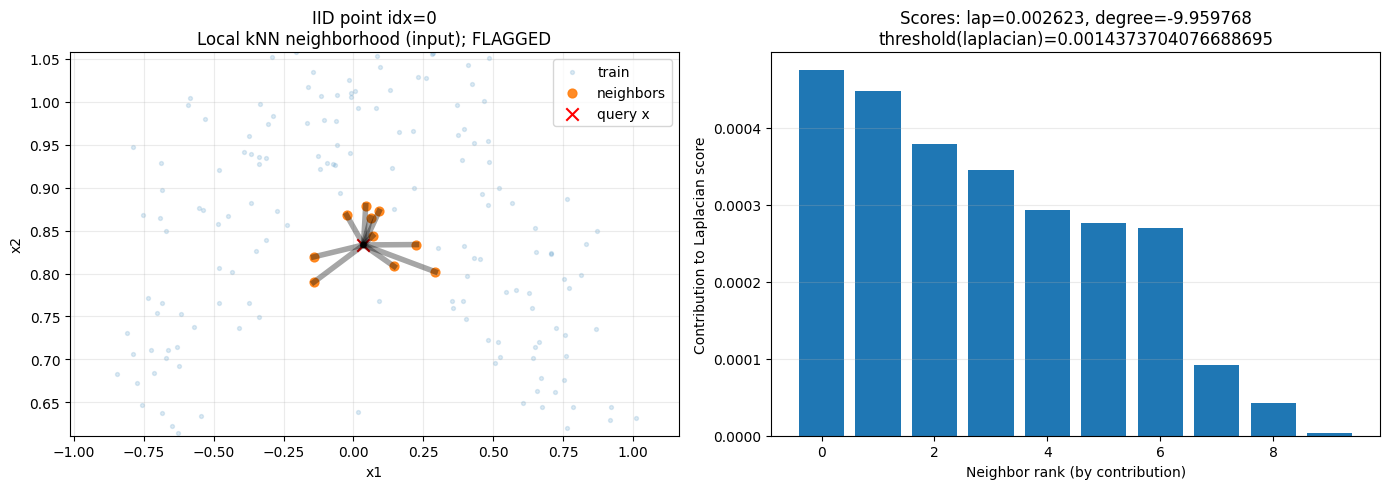

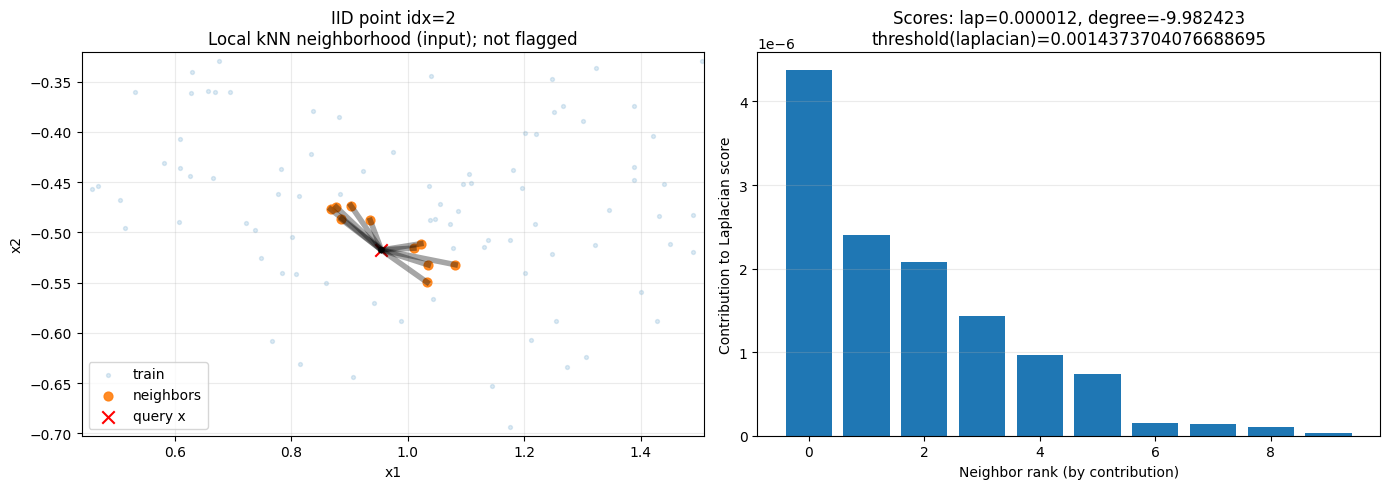

In [ ]:
# Example: visualize one flagged vs one not-flagged point (IID injection)
# Requires you to have run the earlier cell that defines: bundle, det, X_iid, preds_iid

try:
    _bundle = bundle
    _det = det
    _X_iid = X_iid
    _preds = preds_iid
except NameError:
    # Fallback: reproduce a single example run
    EXAMPLE_SEED = BASE_SEEDS[0]
    EXAMPLE_PERCENTILE = 95.0
    _bundle = train_pipeline(EXAMPLE_SEED)
    _det = fit_score_threshold_detector(_bundle['scores_val_clean'], _bundle['scores_val_adv'], score_type=score_type, percentile=float(EXAMPLE_PERCENTILE))
    X_iid, _ = generate_iid_new(N_NEW, noise=_bundle['config'].data.noise, seed=EXAMPLE_SEED + 1000)
    _, _preds = score_and_flag(_bundle, _det, X_iid, score_type=score_type)
    _X_iid = X_iid

flagged_idx = np.where(_preds == 1)[0]
not_flagged_idx = np.where(_preds == 0)[0]

if len(flagged_idx) == 0:
    print("No flagged IID points found in this run; try a lower percentile (e.g. 90) or increase N_NEW.")
else:
    i_flag = int(flagged_idx[0])
    i_ok = int(not_flagged_idx[0])

    visualize_point_graph_neighborhood(
        _bundle, _det, _X_iid[i_flag],
        score_type=score_type,
        title=f"IID point idx={i_flag}",
        plot_space='input',
        zoom=True,
        zoom_margin=2,
    )

    visualize_point_graph_neighborhood(
        _bundle, _det, _X_iid[i_ok],
        score_type=score_type,
        title=f"IID point idx={i_ok}",
        plot_space='input',
        zoom=True,
        zoom_margin=2,
    )

    # Optional: if you want to see the neighborhood in the *feature* space (PCA projection)
    # visualize_point_graph_neighborhood(_bundle, _det, _X_iid[i_flag], score_type=score_type, title=f"IID idx={i_flag}", plot_space='feature_pca')

